# Cluster job tutorial

**Goal:** example of how to use the `Selene_Job` class to send a job to the cluster directly from the local notebook.
  
This notebook is divided in three parts:
* **1. A classic machine learning task example (Gaussian Naive Bayes)**
* **2. How to run the same example on the cluster**
* **3. A more computationally expensive example (grid search on Random Forest)**

In [1]:
%run setup_environment.ipy
%run Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

## A classic machine learning task example (Gaussian Naive Bayes)

In [2]:
# get raw data
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"

# choose label
label = 'is_artefact'

# choose features
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']
impact = impact[features + [label]].dropna()
    
# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
numerical_features = [f for f in features if not f in categorical_features]
impact = pd.get_dummies(impact, columns=categorical_features, sparse=True)

# get reduced dataset
impact = pd.concat([impact[impact.is_artefact],
                    impact[~impact.is_artefact].iloc[:20000]], ignore_index=True)

# shuffle data
rng = np.random.RandomState(42)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]
impact.reset_index(drop=True, inplace=True)

# get features matrix X (n_samples x n_features) and target array y (n_samples)
X = impact.drop(label, axis=1)
X = X.astype(float)
y = impact[label]

print(X.shape)
print(y.shape)
get_table(y)

(27199, 45)
(27199,)


,count_,freq_
False,20000,73.5%
True,7199,26.5%


The code below is at the heart of the computation, it runs the chosen model on the data. This is the code that we want to run on the cluster.

In [17]:
# choose cross-validation strategy
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)

# choose a model
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', GaussianNB())])

# run the model
metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(job.metrics)

Run model... done! (1.77s)
▴ Mean accuracy    : 0.850 ± 0.008
▴ Mean ROC AUC     : 0.857 ± 0.007
▴ Mean F1-score    : 0.625 ± 0.028
▴ Average precision: 0.759 ± 0.013


When we have the metrics we can print/plot any relevant information we want:

In [5]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [0.11s | 0.03s]
  → accuracy     : [0.847 | 0.845]
  → ROC AUC      : [0.860 | 0.855]
  → F1-score     : [0.618 | 0.609]
  → avg precision: [0.759 | 0.751]
Fold 2: [0.11s | 0.03s]
  → accuracy     : [0.853 | 0.853]
  → ROC AUC      : [0.858 | 0.859]
  → F1-score     : [0.631 | 0.632]
  → avg precision: [0.764 | 0.765]
Fold 3: [0.10s | 0.03s]
  → accuracy     : [0.851 | 0.848]
  → ROC AUC      : [0.860 | 0.858]
  → F1-score     : [0.622 | 0.613]
  → avg precision: [0.767 | 0.759]
Fold 4: [0.12s | 0.03s]
  → accuracy     : [0.855 | 0.858]
  → ROC AUC      : [0.852 | 0.864]
  → F1-score     : [0.645 | 0.649]
  → avg precision: [0.750 | 0.773]
Fold 5: [0.11s | 0.03s]
  → accuracy     : [0.846 | 0.849]
  → 

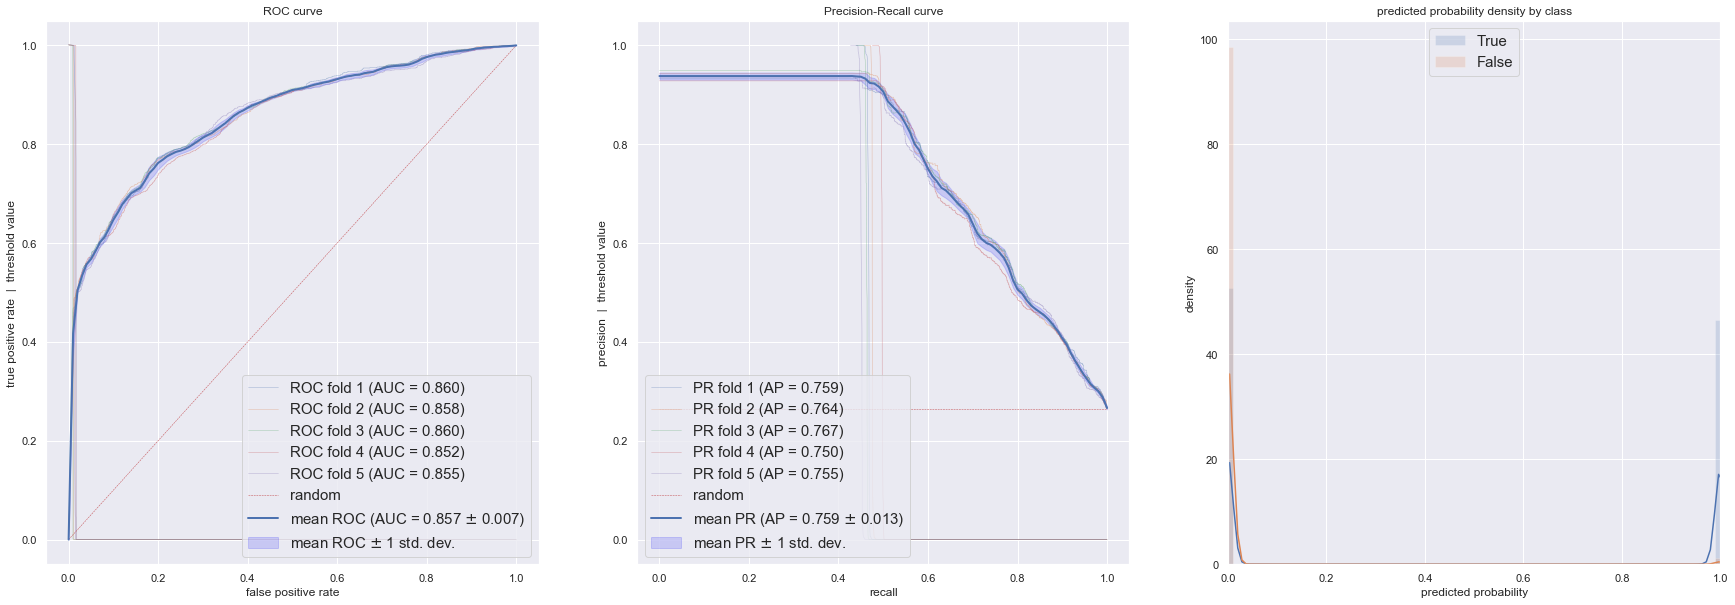

In [6]:
plot_threshold_decision_metrics(metrics)

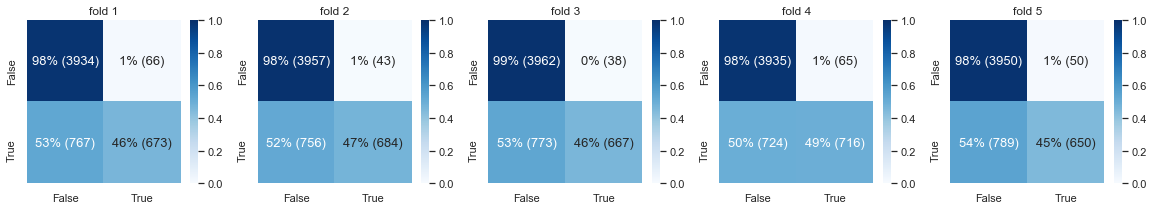

In [7]:
plot_confusion_matrix(metrics)

## How to run the same example on the cluster

### Create a job

We create a job:
* identified by its job id (`cluster_tutorial_Gaussian_NB`)
* referring to a cluster user (`guilminp`)
* refering to an impact-annotator project path on the cluster (`/home/guilminp/impact-annotator`)
* referring to a local path to ssh_remote_jobs (`ssh_remote_jobs`)

This creates a directory named `job_cluster_tutorial_Gaussian_NB` on the local computer, in the `ssh_remote_jobs/` directory.

In [8]:
job = Selene_Job('cluster_tutorial_Gaussian_NB', 'guilminp', '/home/guilminp/impact-annotator', 'ssh_remote_jobs')

➞ mkdir on local computer ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ created

You can also decide to load a previously created job, for example if we want to find back the previous job after logging out:

In [9]:
same_job = Selene_Job('cluster_tutorial_Gaussian_NB', 'guilminp', '/home/guilminp/impact-annotator', 'ssh_remote_jobs', load_from_id = True)

<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ job found and reloaded

Creating an already existing job won't work: 

In [10]:
job = Selene_Job('cluster_tutorial_Gaussian_NB', 'guilminp', '/home/guilminp/impact-annotator', 'ssh_remote_jobs')

<span style="color:red">Job < cluster_tutorial_Gaussian_NB >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

### Load the data used by the job

The following saves `X` and `y` objects as pickle objects in the job directory (`ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB`). This allows to separate the creation of the dataset (feature selection, formating, etc...) from the run of the machine learning model.

In [11]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ data loaded

### Write the job python script

Here we write the ipython script that will be run in the cluster, it is stored in the `script.ipy` file in the local `ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB` folder. Notice that we litteraly copy-paste what we would have written to run the job on a local notebook (ie what we wrote in part 1).

In [12]:
job.script_path

'ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB/script.ipy'

In [13]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')



## EXACT SAME CODE AS IN PART ONE (until ## END)

# choose cross-validation strategy
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)

# choose a model
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', GaussianNB())])
metrics = run_model(model, X, y, cv_strategy)

## END



# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Writing ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB/script.ipy


### Run the job in the cluster

The following command copy the job directory on the cluster, setup the cluster environment and then bsub the job. You can specify the number of jobs, wether it is a short job or not, and the amount of memory in GB per CPU (`memory=None` will assign the default cluster memory value to each CPU):

In [14]:
job.run(n_jobs=1, short_job=True, memory=None) # by default n_jobs=1, short_job=True, memory=None

➞ scp ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  739    77.6KB/s   00:00    
X.pkl                                         100% 6169KB  16.4MB/s   00:00    
y.pkl                                         100%   27KB  47.9KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB
Job <28612912> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J cluster_tutorial_Gaussian_NB -We 59 "ipython script.ipy"


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ submitted<br>

### Get the results of the job

If the job is not done yet we get this result:

In [15]:
job.get_results()

<span style="color:red">Job < cluster_tutorial_Gaussian_NB >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

If it's done, we get this result:

In [16]:
job.get_results()

<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB to ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB
metrics.pkl                                   100%  923KB   9.3MB/s   00:00    
job_output.txt                                100% 1359   418.3KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.850 ± 0.008
▴ Mean ROC AUC     : 0.857 ± 0.007
▴ Mean F1-score    : 0.625 ± 0.028
▴ Average precision: 0.759 ± 0.013


In [18]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [0.09s | 0.03s]
  → accuracy     : [0.847 | 0.845]
  → ROC AUC      : [0.860 | 0.855]
  → F1-score     : [0.618 | 0.609]
  → avg precision: [0.759 | 0.751]
Fold 2: [0.08s | 0.03s]
  → accuracy     : [0.853 | 0.853]
  → ROC AUC      : [0.858 | 0.859]
  → F1-score     : [0.631 | 0.632]
  → avg precision: [0.764 | 0.765]
Fold 3: [0.08s | 0.03s]
  → accuracy     : [0.851 | 0.848]
  → ROC AUC      : [0.860 | 0.858]
  → F1-score     : [0.622 | 0.613]
  → avg precision: [0.767 | 0.759]
Fold 4: [0.09s | 0.03s]
  → accuracy     : [0.855 | 0.858]
  → ROC AUC      : [0.852 | 0.864]
  → F1-score     : [0.645 | 0.649]
  → avg precision: [0.750 | 0.773]
Fold 5: [0.09s | 0.03s]
  → accuracy     : [0.846 | 0.849]
  → 

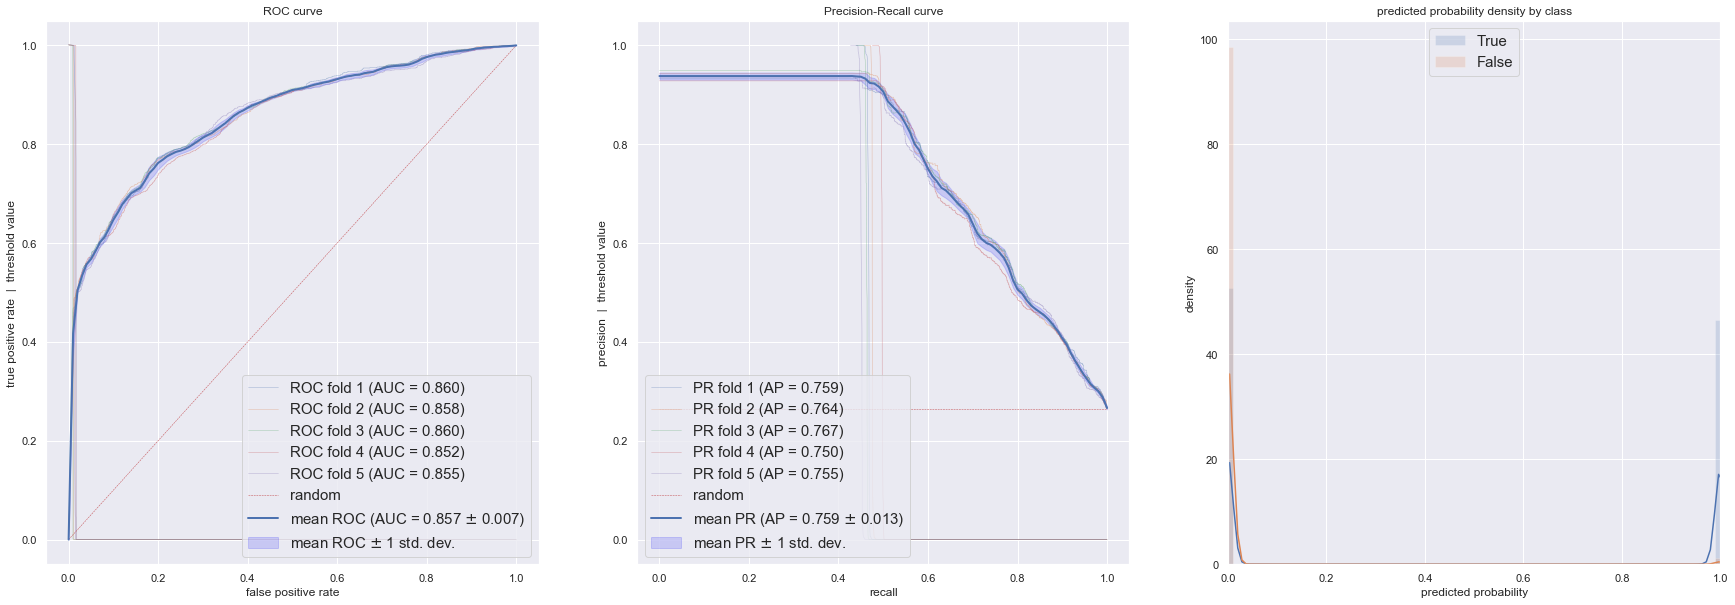

In [19]:
plot_threshold_decision_metrics(job.metrics)

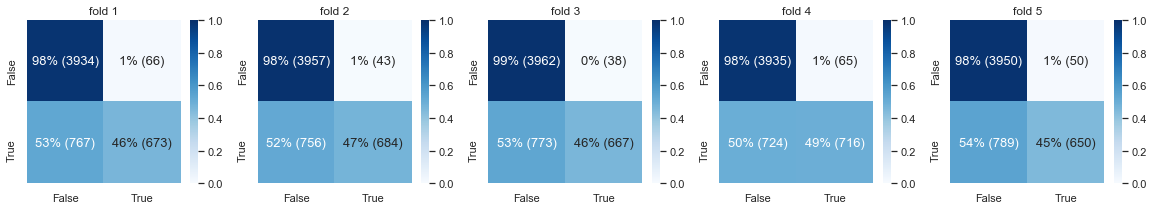

In [20]:
plot_confusion_matrix(job.metrics)

We can remove the job with the following command (it will delete the job directory in the cluster and on the local computer):

In [21]:
job.remove()

➞ rm on local computer ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB
➞ rm on cluster /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_Gaussian_NB


<span style="color:green">Job < cluster_tutorial_Gaussian_NB >: </span>✅ removed from local computer and cluster<br>

## A more computationally expensive example (grid search on Random Forest)

In [22]:
job = Selene_Job('cluster_tutorial_GS_Random_Forest', 'guilminp', '/home/guilminp/impact-annotator', 'ssh_remote_jobs')
job.load_data(X, y)

➞ mkdir on local computer ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest


<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest


<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ data loaded

In [23]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [10, 20, 30], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=20)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Writing ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest/script.ipy


In [24]:
job.run(n_jobs=20, short_job=True, memory=8) # 20 jobs each having 8GB memory

➞ scp ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  902     2.3KB/s   00:00    
X.pkl                                         100% 6169KB  15.6MB/s   00:00    
y.pkl                                         100%   27KB  55.2KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
Job <28613277> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J cluster_tutorial_GS_Random_Forest -We 59 -n 20 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ submitted<br>

In [25]:
job.get_results()

<span style="color:red">Job < cluster_tutorial_GS_Random_Forest >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [26]:
job.get_results()

<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest to ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
metrics.pkl                                   100%  878KB   6.1MB/s   00:00    
job_output.txt                                100% 1278   428.6KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.887 ± 0.009
▴ Mean ROC AUC     : 0.918 ± 0.005
▴ Mean F1-score    : 0.741 ± 0.024
▴ Average precision: 0.869 ± 0.011


In [27]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [8.79s | 0.14s]
  → accuracy     : [0.892 | 0.898]
  → ROC AUC      : [0.922 | 0.932]
  → F1-score     : [0.754 | 0.766]
  → avg precision: [0.877 | 0.896]
  → best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}
Fold 2: [9.41s | 0.13s]
  → accuracy     : [0.888 | 0.900]
  → ROC AUC      : [0.919 | 0.932]
  → F1-score     : [0.743 | 0.770]
  → avg precision: [0.871 | 0.895]
  → best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}
Fold 3: [8.55s | 0.11s]
  → accuracy     : [0.890 | 0.898]
  → ROC AUC      : [0.917 | 0.930]
  → F1-score     : [0.749 | 0.766]
  → avg preci

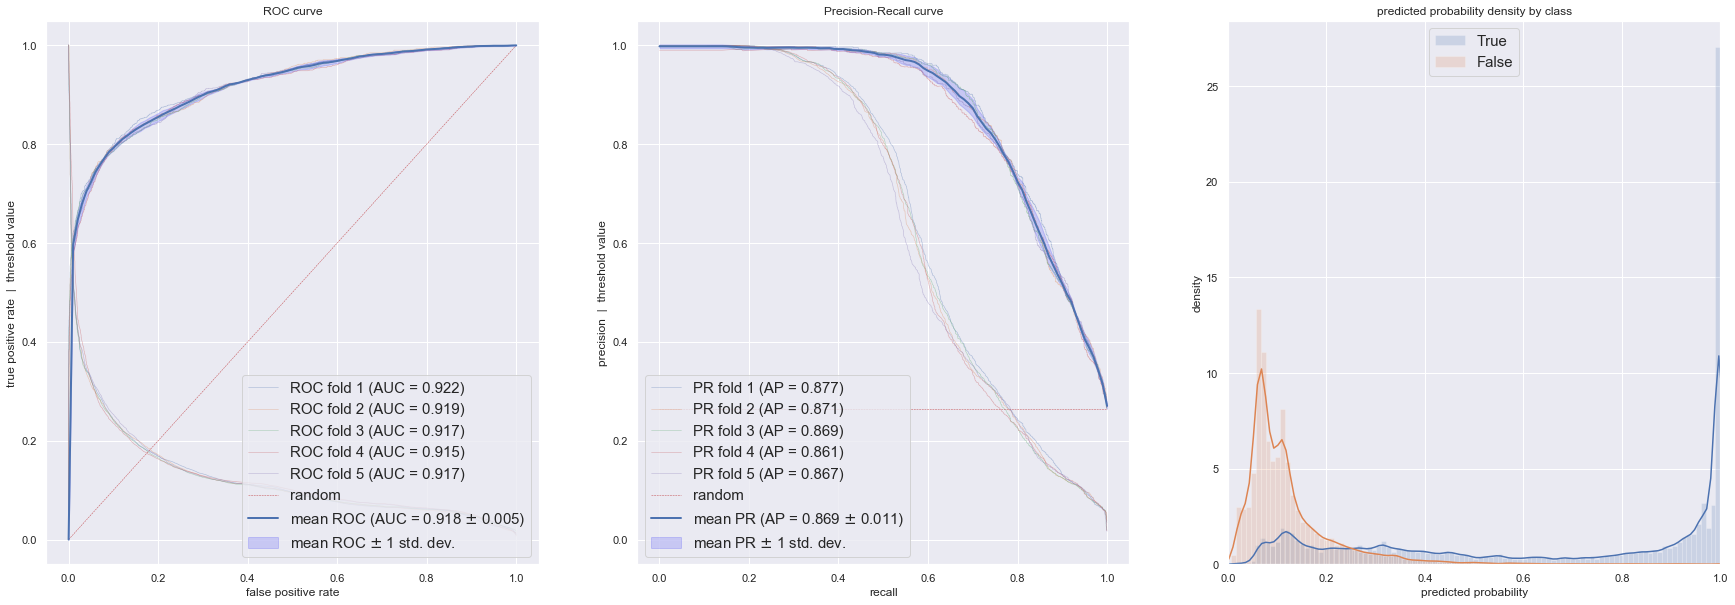

In [28]:
plot_threshold_decision_metrics(job.metrics)

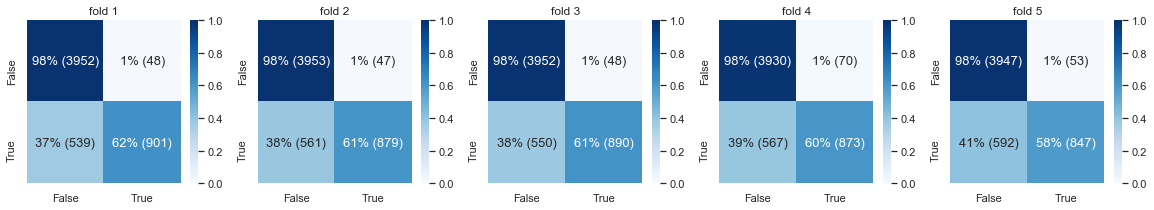

In [29]:
plot_confusion_matrix(job.metrics)

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [5 10]
  → n_estimators: [10 20 30]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}
fold 1: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}
fold 2: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}
fold 3: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}
fold 4: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 30}


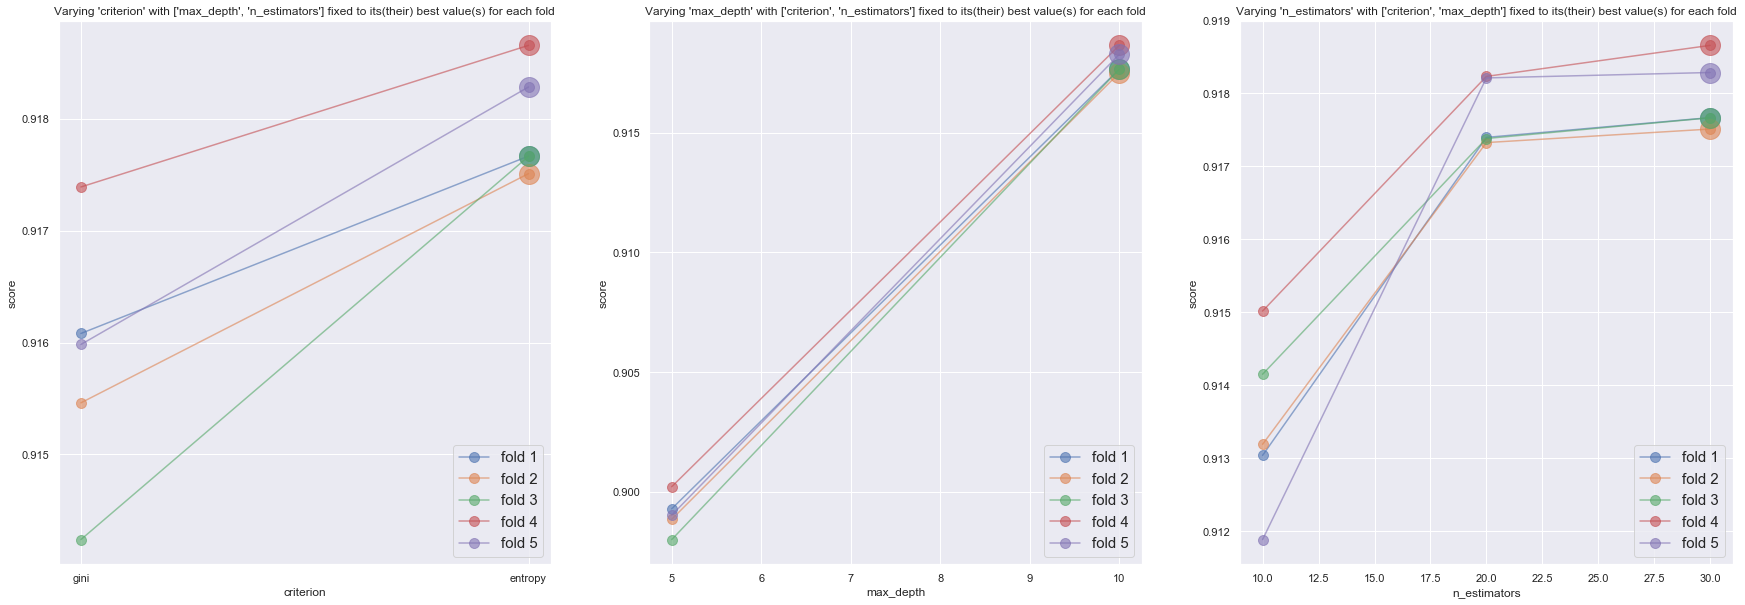

In [31]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [32]:
job.remove()

➞ rm on local computer ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest
➞ rm on cluster /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_cluster_tutorial_GS_Random_Forest


<span style="color:green">Job < cluster_tutorial_GS_Random_Forest >: </span>✅ removed from local computer and cluster<br>